1. Для пайплайна работаем с набором данных с платформы [Kaggle](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers) по оттоку клиентов банка, экспериментируем с разными моделями:
- бустинг
- логистическая регрессия

2. Отобираем лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)
3. Для отобранной модели (на отложенной выборке) делаем оценку экономической эффективности при тех же вводных, как в вопросе 2:
- 1 доллар на удержание
- 2 доллара - с каждого правильно классифицированного (True Positive)

4. *Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. *Еще раз провести оценку экономической эффективности

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 1000)

from sklearn.pipeline import Pipeline, FeatureUnion #, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (f1_score, roc_auc_score, precision_score, 
                             classification_report, precision_recall_curve, 
                             confusion_matrix, ConfusionMatrixDisplay, accuracy_score)

import warnings
warnings.filterwarnings('ignore')

качаем данные:

In [2]:
#!wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O churn_data.csv

Соберём в одном месте разные тех.функции + один класс. Они помогут нам без дублирования кода считать метрики и собирать финансовый результат работы разных алгоритмов в единую сводную таблицу:

In [3]:
def plot_confusion_matrix(cnf_matrix):
    """
    функция для отрисовки confusion_matrix
    """
    cmap = sns.color_palette('Purples')
    plt.figure(figsize=(6, 4))
    sns.heatmap(cnf_matrix, annot=True, cmap=cmap, fmt='g', linewidths=5, vmin=10)
    plt.xlabel('предсказанные значения')
    plt.ylabel('истинные значения')
    accuracy = round((cnf_matrix[0,0]+cnf_matrix[1,1])/sum(sum(cnf_matrix))*100, 2)
    plt.title(f'матрица ошибок (Accuracy: {accuracy}%)\n'
              f'[TN, FP]\n[FN, TP]');


def get_metrics(y_test, preds):
    """
    подсчёт метрик
    """
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # поиск индекса наибольшего значения F
    ix = np.argmax(fscore)
    auc = roc_auc_score(y_test, preds)

    return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score(y_test, preds)


def financial_results(cnf_matrix, retention_cost=1, expected_profit=2):
    """
    финансовый результат, значения для retention_cost expected_profit заданы дефолтные
    """
    TN, FP = cnf_matrix[0][0], cnf_matrix[0][1]
    FN, TP = cnf_matrix[1][0], cnf_matrix[1][1]
    retain_sum = (FP+TP)*retention_cost
    income = TP*expected_profit

    return income - retain_sum


def rename_keys(d, prefix):
    """
    убрать префикс из названия ключа
    """
    return {k.replace(prefix, ''): v for k, v in d.items()}


# числа Фибоначчи
fib = lambda n: reduce(lambda x, _: x + [x[-1] + x[-2]], range(n-2), [0, 1])


class DataFrameEditor:
    """
    класс формирует сводный датафрейм со значениями метрик
    """
    def __init__(self, df=None):
        if df is None:
            self.df = pd.DataFrame(columns=['name_model', 'F-Score', 'Precision', 
                                            'Recall', 'ROC AUC', 'thresh', 'fin_result', 
                                            'best_thresh', 'best_fin_result'])
        else:
            self.df = df
    
    def add_row(self, values_dict):
        """
        метод добавляет новые строки в датафрейм
        """
        new_row = pd.DataFrame(values_dict, index=[0])
        self.df = pd.concat([self.df, new_row], ignore_index=True)
    
    def model_performance_report(self, pipeline, X_train, X_test, y_train, y_test, 
                                 name_model, retention_cost=1, expected_profit=2):
        """
        в методе обучается модель по переданным параметрам
        """
        def get_fin(y_test, probs):
            """поиск лучшей отсечк для фин.результата"""
            add_summ = []
            thresholds = np.linspace(0, 1, 100)
            for i in thresholds:
                cnf_matrix = confusion_matrix(y_test, probs > i)
                TN, FP = cnf_matrix[0][0], cnf_matrix[0][1]
                FN, TP = cnf_matrix[1][0], cnf_matrix[1][1]
                add_summ.append((TP*expected_profit) - ((FP+TP)*retention_cost))
            ix = np.argmax(add_summ)
            return thresholds[ix], add_summ[ix]
            
        # обучим пайплайн
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict_proba(X_test)[:, 1]
        # Подберём порог, после которого мы считаем, что объект можно отнести к классу 1 
        thresholds, fscore, precision, recall, ROC_AUC = get_metrics(y_test, preds)
        cnf_matrix = confusion_matrix(y_test, preds > thresholds)
        plot_confusion_matrix(cnf_matrix)
        fin_result = financial_results(cnf_matrix)

        best_thresh, best_fin = get_fin(y_test, preds)

        self.add_row({'name_model': name_model, 'F-Score': [fscore], 'Precision': [precision], 
                      'Recall': [recall], 'ROC AUC': [ROC_AUC], 'thresh': [thresholds], 
                      'fin_result': [fin_result], 'best_thresh': [best_thresh], 'best_fin_result': [best_fin]}) 

Смотрим на данные:

In [4]:
df = pd.read_csv('churn_data.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


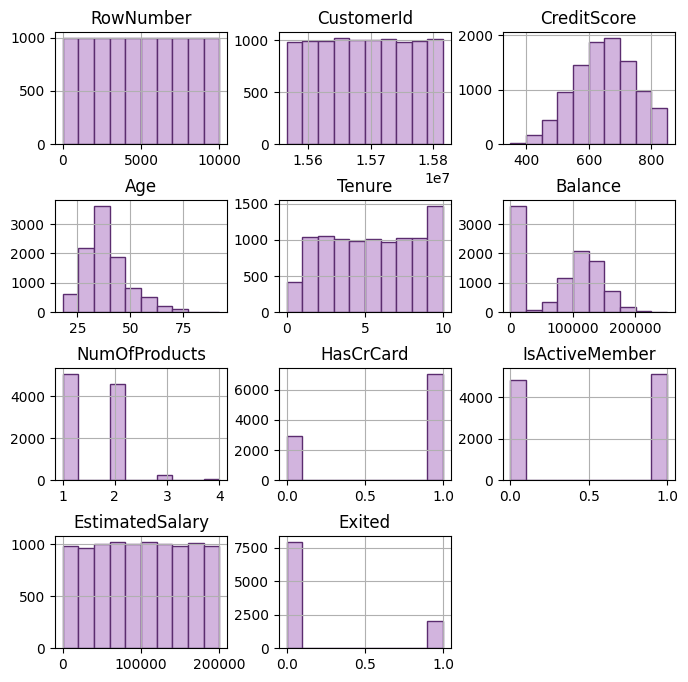

In [5]:
df.select_dtypes(include=np.number).hist(figsize=(8, 8), color='#D2B4DE', ec='#5B2C6F')
plt.subplots_adjust(hspace=0.5);

Есть как категориальные, так и вещественные признаки. 

Посмотрим на распределение классов:

In [6]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Распределение 1 к 4

Разобьём данные:

In [7]:
#разделим данные на train/test
random_state=0
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Exited'), 
                                                    df['Exited'], 
                                                    random_state=random_state)

Категориальные признаки закодируем с помощью OneHotEncoding, а вещественные оставим как есть:

In [8]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Трансформатор для выбора одного столбца из таблицы данных для выполнения 
    дополнительных преобразований. Используется для числовых столбцов в данных.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Зададим списки признаков:

In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Создадим под каждый признак трансформер и объединим их в список ```final_transformers``` и объединим результат в единый пайплайн, который готовит признаки для моделирования:

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

## теперь рассмотрим разные модели, соберём метрики в единую таблицу и посмотрим, будут ли они в потенциале экономически целесообразными.

Алгоритмы, которые мы будем использовать:

1) **```RandomForestClassifier```** - дефолтные параметры и с подбором параметров

2) **```GradientBoostingClassifier```** - дефолтные параметры и с подбором параметров

3) **```LogisticRegression```** - дефолтные параметры и с подбором параметров

4) **```KNeighborsClassifier```** - дефолтные параметры и с подбором параметров


Напомним себе вводные финансовых показателей:

**- удержание одного пользователя уйдет 1 доллар.** 

**- средняя ожидаемая прибыль с каждого TP (true positive) = 2 доллара**

______
______

## **RandomForestClassifier**

дефолтные параметры:

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
0,RandomForest,0.64833,0.64833,0.64833,0.861554,0.37,155,0.484848,184


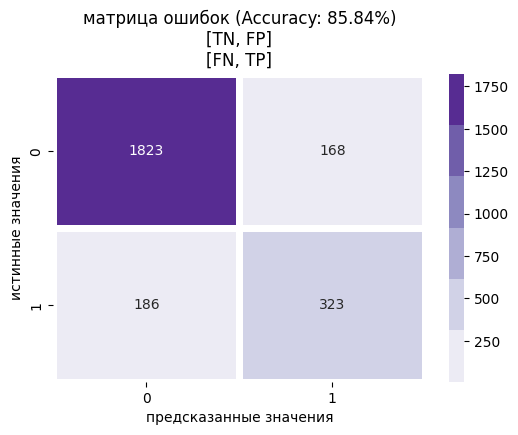

In [11]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=random_state)),
])

df_editor = DataFrameEditor()
df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'RandomForest')
df_editor.df.iloc[[-1]]

параметры через перебор с помощью GridSearch:

In [12]:
%%time
params = {
    'classifier__max_features': np.linspace(0, 1, 5),
    'classifier__min_samples_leaf': range(1, 3),
    'classifier__class_weight': [{0:1, 1:4}, 'balanced_subsample'],
    'classifier__n_estimators': fib(14)[2:]  # range(1, 220, 100) 
}

grid = GridSearchCV(pipeline, param_grid=params, cv=6, refit=False, n_jobs=-1)
search = grid.fit(X_train, y_train)
search.best_params_

CPU times: user 24.5 s, sys: 1.6 s, total: 26.1 s
Wall time: 16min 46s


{'classifier__class_weight': {0: 1, 1: 4},
 'classifier__max_features': 0.25,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 233}

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
1,RandomForest BEST_param,0.652482,0.67364,0.632613,0.868522,0.373391,163,0.434343,181


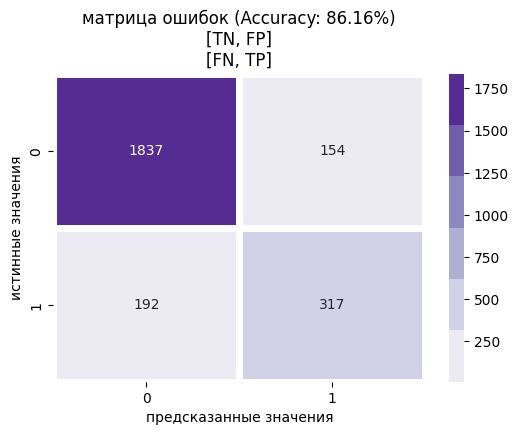

In [13]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(**best_params, random_state=random_state)),
])

df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'RandomForest BEST_param')
df_editor.df.iloc[[-1]]

_____

## **GradientBoostingClassifier**

дефолтные параметры:

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
2,GradientBoosting,0.646121,0.703704,0.59725,0.875753,0.408508,175,0.535354,190


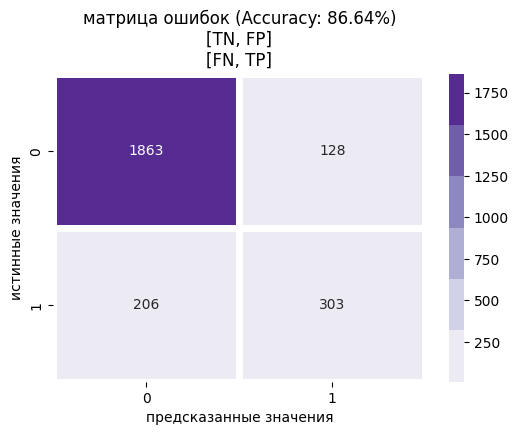

In [14]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=random_state)),
])

df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'GradientBoosting')
df_editor.df.iloc[[-1]]

параметры через перебор с помощью GridSearch:

In [15]:
%%time
params = {
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__n_estimators': [100, 200], 
    'classifier__max_depth': [1, 3, 5],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__subsample': [0.5, 1.0],
}

grid = GridSearchCV(pipeline, param_grid=params, cv=6, refit=False, n_jobs=-1)
search = grid.fit(X_train, y_train)
search.best_params_

CPU times: user 18.3 s, sys: 1.3 s, total: 19.6 s
Wall time: 18min 22s


{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 200,
 'classifier__subsample': 0.5}

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
3,GradientBoosting BEST_param,0.639831,0.694253,0.59332,0.872396,0.414032,168,0.636364,183


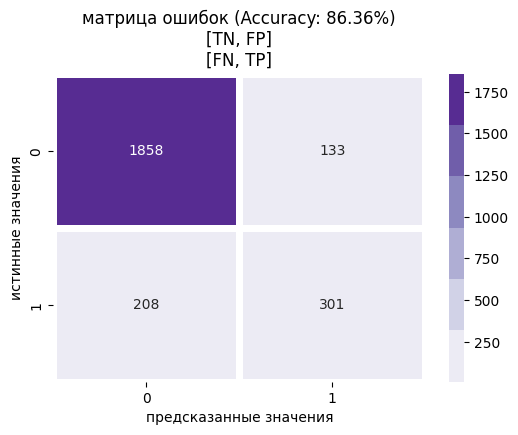

In [16]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(**best_params, random_state=random_state)),
])

df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'GradientBoosting BEST_param')
df_editor.df.iloc[[-1]]

______

## **LogisticRegression**

дефолтные параметры:

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
4,LogisticRegression,0.5097,0.4624,0.56778,0.772077,0.289522,-48,0.545455,36


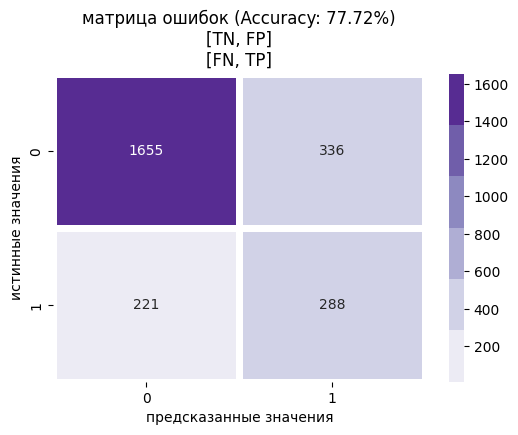

In [17]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=random_state)),
])

df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'LogisticRegression')
df_editor.df.iloc[[-1]]

параметры через перебор с помощью GridSearch:

In [18]:
%%time
params = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__tol': [1e-4, 1e-5, 1e-6],
    'classifier__class_weight': [{0:1, 1:4}, 'balanced']
}

grid = GridSearchCV(pipeline, param_grid=params, cv=6, refit=False)
search = grid.fit(X_train, y_train)
search.best_params_

CPU times: user 59.6 s, sys: 34.4 s, total: 1min 34s
Wall time: 1min 3s


{'classifier__C': 0.01,
 'classifier__class_weight': 'balanced',
 'classifier__penalty': 'l2',
 'classifier__tol': 0.0001}

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
5,LogisticRegression BEST_param,0.515702,0.445078,0.612967,0.776743,0.575139,-78,0.727273,31


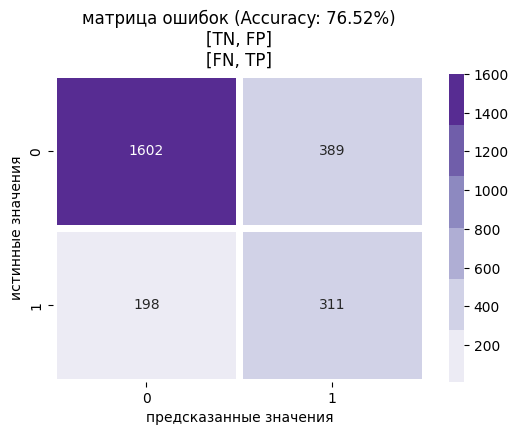

In [19]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(**best_params, random_state=random_state)),
])

df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'LogisticRegression BEST_param')
df_editor.df.iloc[[-1]]

______

## **KNeighborsClassifier**

дефолтные параметры:

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
6,KNeighborsClassifier,0.560641,0.671233,0.481336,0.799837,0.6,91,0.40404,125


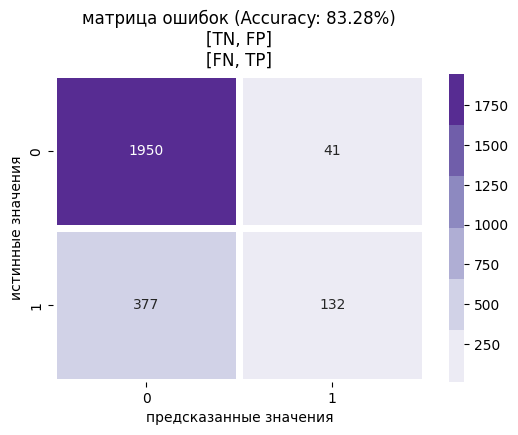

In [20]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', KNeighborsClassifier()),
])

df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'KNeighborsClassifier')
df_editor.df.iloc[[-1]]

параметры через перебор с помощью GridSearch:

In [21]:
%%time
params = {
    'classifier__n_neighbors': range(1, 21),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid = GridSearchCV(pipeline, param_grid=params, cv=6, refit=False)
search = grid.fit(X_train, y_train)
search.best_params_

CPU times: user 4min 49s, sys: 514 ms, total: 4min 49s
Wall time: 4min 22s


{'classifier__algorithm': 'auto',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'uniform'}

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
7,KNeighborsClassifier BEST_param,0.594296,0.558824,0.634578,0.827126,0.363636,131,0.454545,141


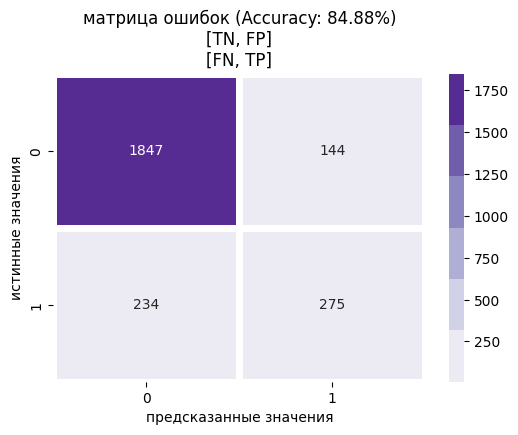

In [22]:
best_params = rename_keys(search.best_params_, 'classifier__')
pipeline = Pipeline([
    ('features', feats),
    ('classifier', KNeighborsClassifier(**best_params)),
])

df_editor.model_performance_report(pipeline, X_train, X_test, y_train, y_test, 
                                   'KNeighborsClassifier BEST_param')
df_editor.df.iloc[[-1]]

______
______

Посмотрим на сводную таблицу работы моделей:

In [23]:
df_editor.df.sort_values(by='best_fin_result', ascending=False)

,name_model,F-Score,Precision,Recall,ROC AUC,thresh,fin_result,best_thresh,best_fin_result
2,GradientBoosting,0.646121,0.703704,0.597250,0.875753,0.408508,175,0.535354,190
0,RandomForest,0.648330,0.648330,0.648330,0.861554,0.370000,155,0.484848,184
3,GradientBoosting BEST_param,0.639831,0.694253,0.593320,0.872396,0.414032,168,0.636364,183
1,RandomForest BEST_param,0.652482,0.673640,0.632613,0.868522,0.373391,163,0.434343,181
7,KNeighborsClassifier BEST_param,0.594296,0.558824,0.634578,0.827126,0.363636,131,0.454545,141
6,KNeighborsClassifier,0.560641,0.671233,0.481336,0.799837,0.600000,91,0.404040,125
4,LogisticRegression,0.509700,0.462400,0.567780,0.772077,0.289522,-48,0.545455,36
5,LogisticRegression BEST_param,0.515702,0.445078,0.612967,0.776743,0.575139,-78,0.727273,31


###**Вывод:** 

Алгоритмы дают разные финансовые результаты и сами по себе и при разных отсечках. 

- *thresh* - это лучшая отсечка с точки зрения Data Science
- *best_thresh* - это лучшая отсечка с точки зрения финансовых результатов бизнеса

Для наилучших бизнес-результатов алгоритм градиентного бустинга с дефолтными параметрами справляется отлично - он возвращает больше денег, соответственно, модель с GradientBoosting для нас наиболее предпочтительна.

Интересна и интерпретация результатов работы модели с случайным лесом:
- лучшие результаты с точки зрения Data Science даёт модель с подобранными гиперпараметрами с помощью GridSearchCV - финансовый результат = 163
- а вот с точки зрения бизнес-показателей и подбора лучшей отсечки по деньгам лучше справился RandomForest с дефолтными параметрами - финансовый результат = 184

Такая разница в результатах подтверждает важность подбора наилучших параметров модели не только с точки зрения Data Science, но и с точки зрения бизнес-логики, когда допустить несклько бóльший отток клиентов бывает выгодней, чем их удерживать.